В данном проекте я провожу анализ поведения пользователей мобильного приложения для бронирования отелей/гостиниц. В рамках проекта:
- созданы синтетические датасеты с информацией о пользователях, их сессиях в приложении, платежах, флоу экранов внутри сессий
- проведен когортный анализ и винтажный анализ rolling retention (7d и 30d) 
- построена воронка конверсий из различных экранов приложения

### 1. Установка соедиения с БД и создание таблиц

Создаем БД с сущностями users, sessions, events и payments

In [76]:
import sqlite3
conn = sqlite3.connect('app.db')

In [77]:
cursor = conn.cursor()

In [78]:
cursor.execute("""
        CREATE TABLE IF NOT EXISTS users(
        user_id INTEGER PRIMARY KEY,
        aq_channel TEXT NOT NULL,
        first_activity_date DATE NOT NULL)""")

users хранит канал привлечения и дату первой покупки 

In [80]:
cursor.execute("""
        CREATE TABLE IF NOT EXISTS sessions(
        session_id BIGINT PRIMARY KEY,
        user_id NOT NULL,
        session_start TIMESTAMP NOT NULL,
        FOREIGN KEY (user_id) REFERENCES users (user_id))""")

sessions хранит все сессии в привязке к юзеру и время старта сессии

In [82]:
cursor.execute("""
        CREATE TABLE IF NOT EXISTS events(
        event_id BIGINT PRIMARY KEY,
        session_id BIGINT NOT NULL,
        event_type TEXT NOT NULL,
        FOREIGN KEY (session_id) REFERENCES sessions (session_id))""")

events хранит события внутри каждой сессии (в нашем случае типом события будет переход юзера на тот или иной экран мобильного приложения)

In [84]:
cursor.execute("""
        CREATE TABLE IF NOT EXISTS payments(
        pay_id BIGINT PRIMARY KEY,
        user_id INTEGER NOT NULL,
        pay_date DATE NOT NULL,
        pay_amount REAL NOT NULL,
        FOREIGN KEY (user_id) REFERENCES users (user_id))""")

payments хранит платежи - их юзера, дату платежа (покупки), размер платежа (в у.е.) 

### 2. Генерация и загрузка синтетических данных

In [87]:
from faker import Faker #Faker - класс, создающий генератор
import numpy as np
import pandas as pd
import datetime
fake = Faker() #fake - экземпляр генератора. у него есть методы для генерации данных
#(типа fake.name(), fake.street() и т.д.)

In [88]:
#начальные условия. 12000 уникальных юзеров и рассматриваемый период - 2024 год
users_num = 12000
START_DATE = datetime.datetime(2024,1,1)
END_DATE = datetime.datetime(2024,12,31)

In [89]:
def generate_users(n):
    channels = ['organic', 'vk', 'telegram', 'yandex_ads', 'tiktok'] #каналы привлечения
    users = []
    for id in range(n):
        users.append({
            'user_id': id,
            'acquisition_channel': np.random.choice(channels, p=[0.1, 0.2, 0.25, 0.15, 0.3]),
            'registration_date': fake.date_between(START_DATE, END_DATE)
        })
    return pd.DataFrame(users)

Генерируем для каждого пользователя один из каналов привлечения и дату регистрации (первого взаимодействия с приложением)

In [91]:
def generate_sessions(users_df, sessions_per_user=5):
    sessions = []
    session_counter = 0
    for ind, user in users_df.iterrows(): 
        sessions.append({
                'session_id':session_counter,
                'user_id': user['user_id'],
                'session_start': fake.date_time_between(
                    start_date=user['registration_date'], 
                    end_date = user['registration_date'] + datetime.timedelta(days=1) 
                )})
        session_counter += 1
        #моделируем кол-во сессий на пользователя
        if user['acquisition_channel'] == 'organic':
            sessions_num = max(1, int(np.random.poisson(sessions_per_user)))
        else:
            sessions_num = max(1, int(np.random.exponential(sessions_per_user)))
        for i in range(sessions_num):
            sessions.append({
                'session_id':session_counter,
                'user_id': user['user_id'],
                'session_start': fake.date_time_between(
                    start_date=user['registration_date'], 
                    end_date=END_DATE
                )})
            session_counter += 1
    return pd.DataFrame(sessions)

Преполагаем, что кол-во сессий на пользователя имеет пуассоновское (если канал привлечение - органика) и экспоненциальное (во всех остальных случаях) распределение со средним, равным sessions_per_user = 5 

In [93]:
def generate_events(sessions_df):
    
    screen_types = ['main','cart','search','product','order_registration','payment','success'] #типы экранов в маркетплейсе
    events = []

    next_screen_options = {
            'main': ['search', 'product','cart'],
            'search': ['product', 'main'],
            'product': ['cart', 'search', 'main'],
            'cart': ['main', 'product','order_registration'],
            'order_registration':['payment','cart'],
            'payment': ['success','order_registration'],
            'success': ['main']}  #словарь из возможных следующих экранов для текущего экрана
    
    event_counter = 0
    for ind, session in sessions_df.iterrows():
        #кол-во экранов внутри сессии распр. нормально, при этом больше 2 и меньше 10
        screens_num = int(max(2, min(10, np.random.normal(5,2)))) 
        screen_flow = ['main'] #первый экран - главная
        events.append({
        'event_id':event_counter,
        'session_id':session['session_id'],
        'event_type':'main'})  
        event_counter += 1
        for i in range(1, screens_num):
            previous_screen = screen_flow[i-1]
            current_screen = np.random.choice(list(next_screen_options.get(previous_screen)))
            screen_flow.append(current_screen)
            events.append({
                'event_id':event_counter,
                'session_id':session['session_id'],
                'event_type':current_screen})  
            event_counter += 1

    return pd.DataFrame(events)

In [71]:
cursor.execute("""DROP TABLE users""")
cursor.execute("""DROP TABLE sessions""")
cursor.execute("""DROP TABLE events""")
cursor.execute("""DROP TABLE payments""")
cursor.execute("""DROP TABLE cohort_retention""")
conn.commit()

Генерируем события (флоу переходов по разным экранам приложения) внутри каждой сессии.

In [105]:
def generate_payments(users_df, avg_purchase_num = 12):
    payments = []
    payments_counter = 0
    for ind, user in users_df.iterrows():
        payments_num = np.random.poisson(avg_purchase_num) #кол-во покупок на юзера
        if payments_num > 0:
            for i in range(payments_num):
                payments.append({
                    'pay_id':payments_counter,
                    'user_id':user['user_id'],
                    'pay_date':fake.date_between(
                        start_date=user['registration_date'], 
                        end_date=END_DATE),
                    'pay_amount':round(np.random.lognormal(3,1),2)})
                payments_counter += 1
    return pd.DataFrame(payments)    

Генерируем платежи (покупки) каждого пользователя. 

In [107]:
#создаем датасеты
users_df = generate_users(users_num)
sessions_df = generate_sessions(users_df)
events_df = generate_events(sessions_df)
payments_df = generate_payments(users_df)

In [108]:
#переносим датасеты в таблицы с помощью созданного sqlite соединения conn
users_df.to_sql('users', conn, if_exists = 'replace', index = False)
sessions_df.to_sql('sessions', conn, if_exists = 'replace', index = False)
events_df.to_sql('events', conn, if_exists = 'replace', index = False)
payments_df.to_sql('payments', conn, if_exists = 'replace', index = False)

144203

In [109]:
conn.commit()

### 3. Анализ Retention по когортам (по каналу привлечения)

Будем делить пользователей на когорты по каналу привлечения и месяцу, когда они зарегистрировались (привлеченные пользователи = зарегистрировавшиеся пользователи).
Когорта определяется каналом привлечения и месяцем регистрации.
Учитывая специфику нашего сервиса (люди пользуются нашим приложением для бронировая путешествий несколько раз в год), будем рассчитывать не классический retention (ровно на 7-й и 30-й день), а rolling retention, где в числителе - кол-во юзеров, у которых последняя активность в приложении была после 7 (30) дней после регистрации. Так мы анализируем сохранение интереса пользователей к нашему приложению.

In [113]:
#создаем таблицу с retention
cursor.execute("""
CREATE TABLE IF NOT EXISTS cohort_retention (
    aq_channel TEXT,
    cohort_month TEXT,
    cohort_size INTEGER,
    retention_7_day REAL,
    retention_30_day REAL
); """)

In [ ]:
#проверяем, что данные попали в БД
cursor.execute("""SELECT * FROM users""")
rows = cursor.fetchall()
print(rows) 

In [117]:
#рассчитываем rolling retention (7d и 30d) по когортам. если когорта пустая, то NULL, вставляем данные в таблицу с retention
cursor.execute("""
        INSERT INTO cohort_retention
        WITH 
        cohorts AS (
           SELECT 
               user_id, 
               acquisition_channel, 
               strftime('%Y-%m', registration_date) AS cohort_month
           FROM users
        ),
        user_activities AS (
           SELECT
               c.cohort_month,
               u.acquisition_channel,
               u.user_id,
               CAST((julianday(date(s.session_start)) - julianday(date(u.registration_date))) AS INTEGER) AS days_passed_after_reg
           FROM sessions s
           JOIN users u ON u.user_id = s.user_id
           JOIN cohorts c ON c.user_id = u.user_id
        )
        SELECT 
            acquisition_channel,
            cohort_month,
            COUNT(DISTINCT CASE WHEN days_passed_after_reg = 0 THEN user_id END) AS cohort_size,
            ROUND(
                COUNT(DISTINCT CASE WHEN days_passed_after_reg >= 7 THEN user_id END) * 100.0 / 
                NULLIF(COUNT(DISTINCT CASE WHEN days_passed_after_reg = 0 THEN user_id END), 0), 1) 
                AS day_7_rol_retention,
            ROUND(
                COUNT(DISTINCT CASE WHEN days_passed_after_reg >= 30 THEN user_id END) * 100.0 / 
                NULLIF(COUNT(DISTINCT CASE WHEN days_passed_after_reg = 0 THEN user_id END), 0),1) 
                AS day_30_rol_retention
        FROM user_activities
        GROUP BY acquisition_channel, cohort_month
        ORDER BY acquisition_channel, cohort_month;
""")

In [119]:
conn.commit() #изменили БД

In [121]:
#проверяем, что данные дошли
cursor.execute("""SELECT * FROM cohort_retention""")
rows = cursor.fetchall()
for row in rows:
    print(row)

('organic', '2024-01', 93, 100.0, 100.0)
('organic', '2024-02', 91, 100.0, 100.0)
('organic', '2024-03', 84, 100.0, 100.0)
('organic', '2024-04', 101, 100.0, 100.0)
('organic', '2024-05', 110, 100.0, 100.0)
('organic', '2024-06', 92, 100.0, 100.0)
('organic', '2024-07', 98, 100.0, 100.0)
('organic', '2024-08', 108, 98.1, 96.3)
('organic', '2024-09', 122, 100.0, 100.0)
('organic', '2024-10', 98, 100.0, 98.0)
('organic', '2024-11', 102, 99.0, 74.5)
('organic', '2024-12', 103, 76.7, 0.0)
('telegram', '2024-01', 241, 99.6, 97.9)
('telegram', '2024-02', 230, 99.1, 98.3)
('telegram', '2024-03', 263, 99.6, 96.6)
('telegram', '2024-04', 228, 99.1, 96.9)
('telegram', '2024-05', 291, 99.3, 95.2)
('telegram', '2024-06', 235, 99.6, 97.4)
('telegram', '2024-07', 270, 99.3, 94.1)
('telegram', '2024-08', 248, 98.8, 92.7)
('telegram', '2024-09', 226, 97.8, 88.5)
('telegram', '2024-10', 260, 98.1, 86.9)
('telegram', '2024-11', 220, 89.5, 59.1)
('telegram', '2024-12', 243, 63.4, 0.0)
('tiktok', '2024-01

In [123]:
retention_df = pd.read_sql("SELECT * FROM cohort_retention",conn)

In [125]:
retention_df

,aq_channel,cohort_month,cohort_size,retention_7_day,retention_30_day
0,organic,2024-01,93,100.0,100.0
1,organic,2024-02,91,100.0,100.0
2,organic,2024-03,84,100.0,100.0
3,organic,2024-04,101,100.0,100.0
4,organic,2024-05,110,100.0,100.0
5,organic,2024-06,92,100.0,100.0
6,organic,2024-07,98,100.0,100.0
7,organic,2024-08,108,98.1,96.3
8,organic,2024-09,122,100.0,100.0
9,organic,2024-10,98,100.0,98.0


Высокие показатели rolling retention объясняются тем, что данные синтетитческие (даты сессий - рандомные даты из 2024г)

### 4. Построение воронок конверсий для экранов приложения

Рассчитаем поэтапные конверсии для этапов cart -> order_registration (корзина -> оформление заказа)
                                          order_registration -> payment (оформление заказа -> страница платежа)
                                          payment -> success (страница платежа -> успешная оплата) для января 2024

In [ ]:
cursor.execute("""SELECT * FROM events LIMIT 100""")
rows = cursor.fetchall()
for row in rows:
    print(row)

In [200]:
#выборка сессий за январь 2024
user_events_df = pd.read_sql("""
        SELECT * FROM 
        events e JOIN sessions s on s.session_id = e.session_id 
        where date(s.session_start) BETWEEN '2024-01-01' AND '2024-01-30'""", conn) 

In [202]:
user_events_df

,event_id,session_id,event_type,session_id,user_id,session_start
0,691,147,main,147,27,2024-01-10 03:52:39
1,692,147,search,147,27,2024-01-10 03:52:39
2,1577,347,main,347,54,2024-01-26 20:00:03
3,1578,347,search,347,54,2024-01-26 20:00:03
4,1579,347,main,347,54,2024-01-26 20:00:03
...,...,...,...,...,...,...
5455,315027,68630,product,68630,11971,2024-01-23 08:33:12
5456,315028,68630,cart,68630,11971,2024-01-23 08:33:12
5457,315029,68630,main,68630,11971,2024-01-23 08:33:12
5458,315030,68630,product,68630,11971,2024-01-23 08:33:12


In [204]:
user_events_df.columns.values[3] = "duplicate"

In [ ]:
user_events_df.drop(columns = ['duplicate'])

In [210]:
sessions = user_events_df['session_id'].unique().tolist()

In [216]:
#восстанавливаем флоу экранов для каждой сессии
sessions_flow = []
for session_id in sessions:
   cur_flow = list(user_events_df.loc[user_events_df['session_id'] == session_id, 'event_type'])
   sessions_flow.append({'session_id':session_id,
                         'screen_flow':cur_flow})
sessions_flow = pd.DataFrame(sessions_flow)

In [218]:
sessions_flow

,session_id,screen_flow
0,147,"[main, search]"
1,347,"[main, search, main, search, main, cart, order..."
2,355,"[main, cart, main, product]"
3,363,"[main, search, main, cart]"
4,565,"[main, product, cart, order_registration]"
...,...,...
1187,68532,"[main, search, product, search, product, main]"
1188,68537,"[main, cart]"
1189,68538,"[main, search]"
1190,68609,"[main, product, search, product]"


In [250]:
#функция для проверки наличия различных переходов с экрана на экран внутри флоу сессии
def chain_in_list(lst,lst_chain):
    return any(lst[i:i+len(lst_chain)] == lst_chain for i in range(len(lst) - len(lst_chain) + 1))

In [ ]:
#отмечаем 1 сессии, где реализуется тот или иной сценарий
sessions_flow['cart'] = sessions_flow['screen_flow'].apply(lambda x: chain_in_list(x, ['cart']))
sessions_flow['order_registration'] = sessions_flow['screen_flow'].apply(lambda x: chain_in_list(x, ['order_registration']))
sessions_flow['payment'] = sessions_flow['screen_flow'].apply(lambda x: chain_in_list(x, ['payment']))
sessions_flow['success'] = sessions_flow['screen_flow'].apply(lambda x: chain_in_list(x, ['success']))

sessions_flow['cart_to_order'] = sessions_flow['screen_flow'].apply(lambda x: chain_in_list(x,['cart','order_registration']))
sessions_flow['order_registration_to_pay'] = sessions_flow['screen_flow'].apply(lambda x: chain_in_list(x, ['order_registration','payment']))
sessions_flow['payment_to_success'] = sessions_flow['screen_flow'].apply(lambda x: chain_in_list(x,['payment','success']))

sessions_flow = sessions_flow.replace({True:1, False:0})

In [270]:
#считаем три поэтапные конверсии (за базу каждый раз ерется предыдщий, а не самый первый шаг)
conv1 = sum(sessions_flow['cart_to_order'])/sum(sessions_flow['cart'])
conv2 = sum(sessions_flow['order_registration_to_pay'])/sum(sessions_flow['order_registration'])
conv3 = sum(sessions_flow['payment_to_success'])/sum(sessions_flow['payment'])
print(conv1, conv2, conv3)

0.3036935704514364 0.38738738738738737 0.3372093023255814


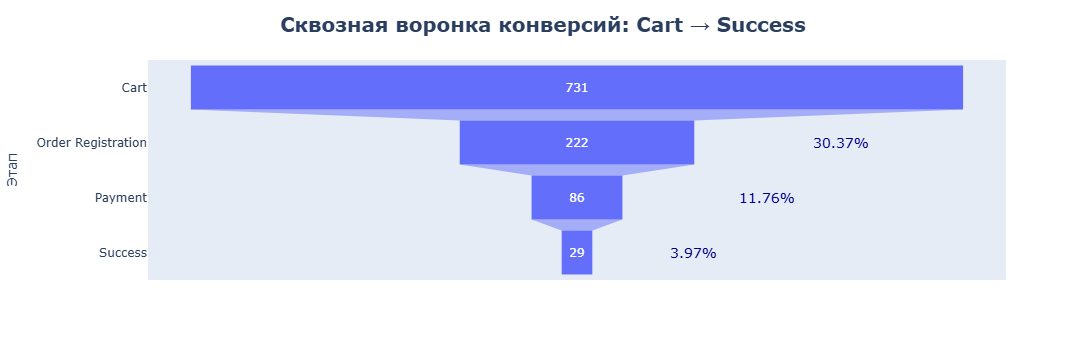

In [328]:
#визуализируем воронку
import plotly.express as px

funnel = pd.DataFrame({
    "Этап": ["Cart", "Order Registration", "Payment", "Success"],
    "Сессии": [sum(sessions_flow['cart']),  sum(sessions_flow['cart_to_order']), \
               sum(sessions_flow['order_registration_to_pay']), sum(sessions_flow['payment_to_success'])]
})
fig = px.funnel(funnel, x="Сессии", y="Этап")

fig.update_layout(
    title={
        'text': "<b>Сквозная воронка конверсий: Cart → Success</b>",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}
    }
)

#Добавляем подпись с конверсией 
fig.add_annotation(
    x=250,   #абсолютное значение из оси Х
    y="Order Registration", #категория из оси Y
    text=f"{round(conv1*100,2)}%",
    showarrow=False,
    xref="x",  # Привязка к оси X данных (не к области графика)
    yref="y",  #привязка к оси Y данных (у данных по оси Y категории)
    font={'size': 14, 'color': 'darkblue'}
)
#Добавляем подпись с конверсией 
fig.add_annotation(
    x=180, 
    y="Payment",
    text=f"{round(conv1*conv2*100,2)}%",
    showarrow=False,
    xref="x",  # Привязка к оси X данных (не к области графика)
    yref="y", 
    font={'size': 14, 'color': 'darkblue'}
)
#Добавляем подпись с конверсией 
fig.add_annotation(
    x=110, 
    y="Success", 
    text=f"{round(conv1*conv2*conv3*100,2)}%",
    showarrow=False,
    xref="x",  # Привязка к оси X данных (не к области графика)
    yref="y", 
    font={'size': 14, 'color': 'darkblue'}
)

fig.show()